In [33]:
library(tidyverse)
if (!require(data.table)) install.packages("data.table")

ws_namespace <- Sys.getenv('WORKSPACE_NAMESPACE')
ws_name <- Sys.getenv('WORKSPACE_NAME')
ws_bucket <- Sys.getenv('WORKSPACE_BUCKET')  # References workspace bucket ("gs://fc-secure-...")

In [34]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Import and read in files 

## COVID-19 phenotypes

In [35]:
# system(paste0("gsutil cp ", ws_bucket, "/covid_phenotypes_20201008/covid19* ."))
# system(paste0("gsutil cp ", ws_bucket, "/covid_phenotypes_20201008/death* ."))

covid_raw_result_df <- fread("covid19_result.20201008.txt", stringsAsFactors = F)
# covid_emis_df <- fread("covid19_emis_gp_clinical.20201008.txt", stringsAsFactors = F)
# covid_tpp_df <- fread("covid19_tpp_gp_clinical.20201008.txt", stringsAsFactors = F)
death_date_df <- fread("death.20201008.txt", stringsAsFactors = F)
death_cause_df <- fread("death_cause.20201008.txt", stringsAsFactors = F)

In [36]:
# head(covid_raw_result_df)
table(covid_raw_result_df$origin)


    0     1 
 7639 20145 

### COVID test results

In [37]:
covid_test_df <- covid_raw_result_df %>%
  select(id=eid, result) %>%
  group_by(id) %>%
  summarise(test_positive = any(result == 1))

dim(covid_test_df)
# head(covid_test_df)
table(covid_test_df$test_positive)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 18221     2


FALSE  TRUE 
16508  1713 

### COVID test results and hospitalization 

In [38]:
covid_df <- covid_raw_result_df %>%
  mutate(test_positive = ifelse(result == 1, 1, 0),  # Test positive based on "result" field
         hosp1 = ifelse(reqorg == 1, 1, 0),  # Higher-specificity definition
         hosp2 = ifelse(  # Higher-sensitivity definition
           ((reqorg %in% c(1, 5)) | (acute == 1) | (hosaq == 1)) &
           reqorg != 4,
         1, 0),
         case_b2 = ifelse(hosp2 & test_positive, 1, 0),
#          case_c2 = ifelse(test_positive & ()) 
        ) %>%
  select(id=eid, hosp2, test_positive, case_b2) %>%
  group_by(id) %>%
  summarise(case_b2 = ifelse(any(case_b2 == 1), 1, 0))

dim(covid_df)
# head(covid_df)
table(covid_df$case_b2)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 18221     2


    0     1 
17183  1038 

### COVID death causes

In [39]:
covid_death_df <- death_cause_df %>%
  filter(cause_icd10 %in% c("U071", "U072")) %>%
  mutate(covid_death = TRUE) %>%
  select(id=eid, death_cause_icd10=cause_icd10, covid_death)

dim(covid_death_df)
# head(covid_death_df)
table(covid_death_df$death_cause_icd10)

[1] 457   3


U071 U072 
 436   21 

### COVID severe respiratory support/death

In [40]:
a <- covid_df %>%
  left_join(covid_death_df, by="id") %>%
  mutate(covid_death = ifelse(!is.na(covid_death), 1, 0)
#          resp_support = .....,
#          case_c2 = case_when(
#            test_positive & hosp2 & resp ~ 1,  # Respiratory support
#            test_positive & hosp2 & !resp & covid_death ~ 1,  # Death w/out respiratory support
#            TRUE ~ 0  # Everyone else is a control
#          )
         )

## Social determinants of health

In [41]:
system(paste0("gsutil cp ", ws_bucket, "/phenotypes/ukb44293.tab.gz ."))
system("gunzip ukb44293.tab.gz")
sdh_df <- fread("ukb44293.tab", data.table = F, stringsAsFactors = F) %>%
  select(id=f.eid, mdi=f.26410.0.0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 69772 rows containing non-finite values (stat_bin).”


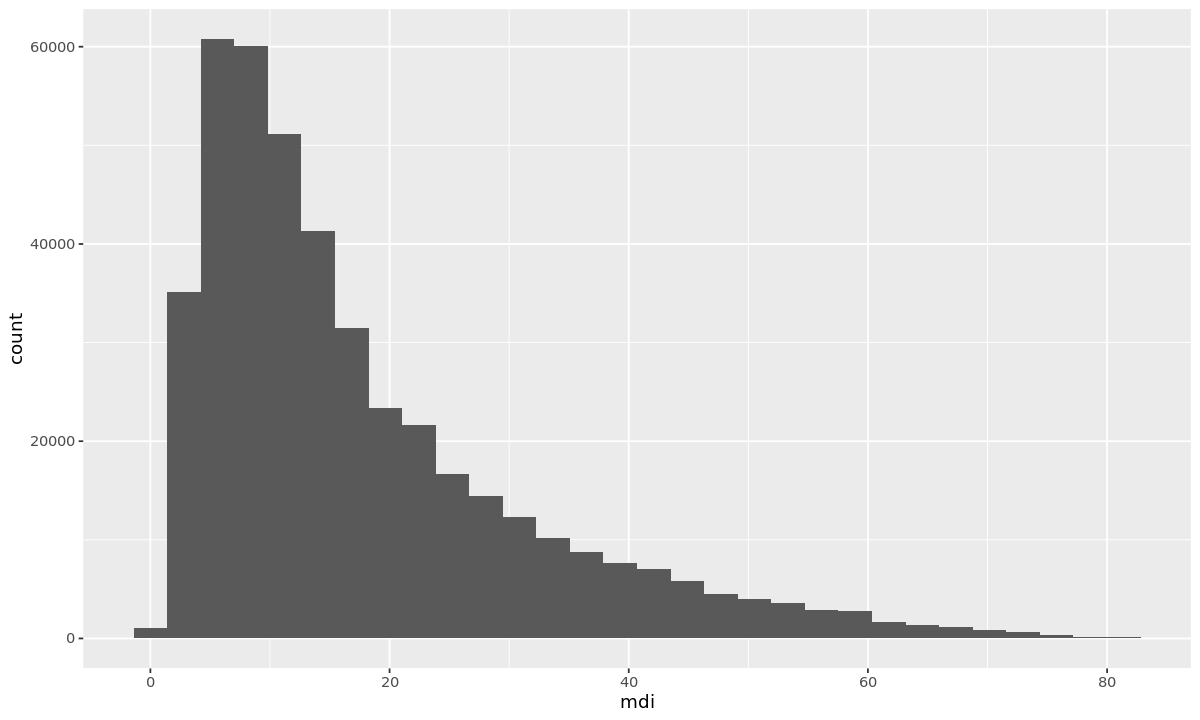

In [42]:
sdh_df %>%
  ggplot(aes(x=mdi)) +
  geom_histogram()

## Other phenotypes

* Read in various phenotype files
* Create ancestry-specific files with criteria:
    - Unrelated
    - Passing QC
    - Consent not withdrawn
* Final output of this section has all exposures and covariates

In [43]:
system(paste0("gsutil cp ", ws_bucket, "/phenotypes/* ."))
afr_df <- fread("UKB_genoQC_AFR_N7447_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)
eas_df <- fread("UKB_genoQC_EAS_N2264_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)
eur_df <- fread("UKBiobank_genoQC_reportedANDgeneticEUR_N455146_FLOREZ_EUR_PCA_covariates_40dim.txt", data.table = F, stringsAsFactors = F)
sas_df <- fread("UKB_genoQC_SAS_N8669_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)
withdrawn_consent <- scan("w27892_20200820.csv")

In [44]:
sample_df <- bind_rows(list(
  AFR = afr_df,
  EAS = eas_df,
  EUR = eur_df,
  SAS = sas_df
), .id="ancestry") %>%
  mutate(array = ifelse(ancestry == "EUR", genotyping.array, cov_GENO_ARRAY)) %>%
  filter(!(Florez_IID %in% withdrawn_consent),
         unrelateds == 1) %>%
  select(id=Florez_IID, ancestry, paste0("PC", 1:10), array)

In [45]:
exp_and_cov_df <- fread("UKBiobank_ALLethnicities_diabetes_complete_2020Feb.txt") %>%
  mutate(sexMale = as.integer(f.31.0.0 == "Male")) %>%
  select(id=f.eid, sexMale, age=f.21022.0.0,
         bmi=f.21001.0.0, t2d=prob_poss_t2dm_all)

In [46]:
pheno_df <- sample_df %>%
  inner_join(exp_and_cov_df, by="id") %>%
  left_join(sdh_df, by="id")


   AFR    EAS    EUR    SAS 
  6806   2173 378054   7895 


     0      1 
212936 181992 


     0      1 
376059  18869 

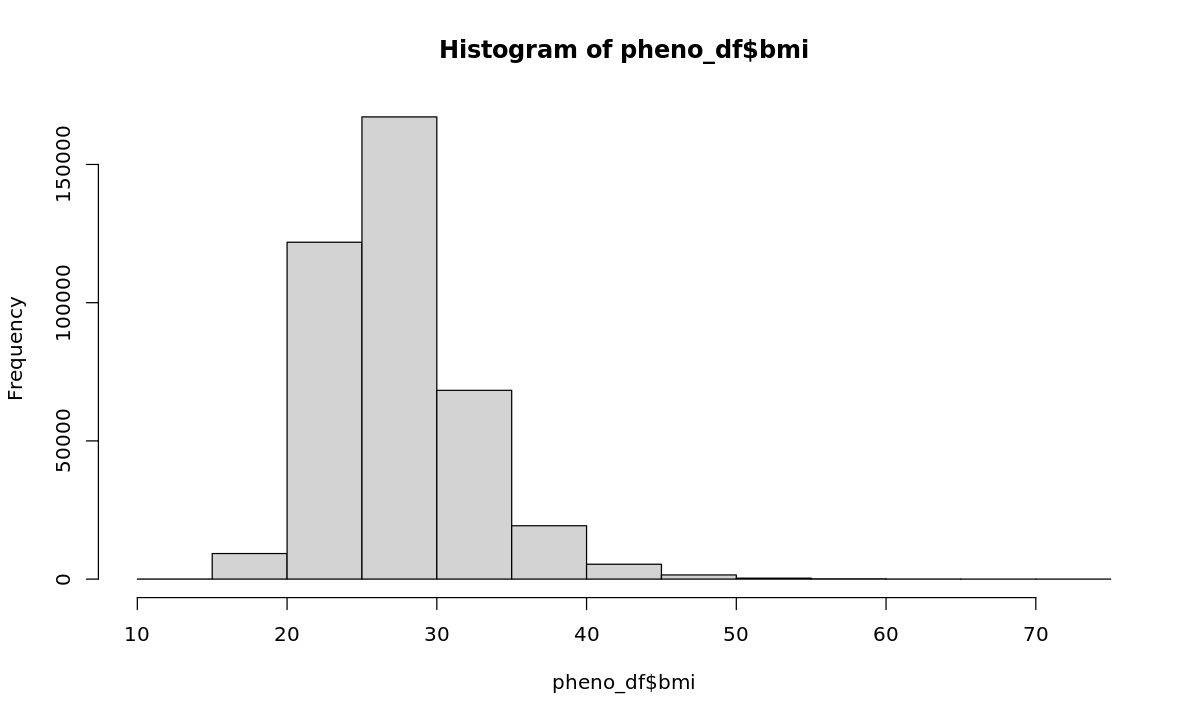

In [47]:
table(pheno_df$ancestry)
table(pheno_df$sex)
hist(pheno_df$bmi)
table(pheno_df$t2d)

## Merge datasets and write to file

In [48]:
# Join covariates + exposures data frame with Covid data frame
final_pheno_df <- pheno_df %>%
  left_join(covid_df, by="id") %>%
  replace_na(list(case_b2=0))

In [49]:
dim(final_pheno_df)
names(final_pheno_df)
with(final_pheno_df, table(ancestry, case_b2))

[1] 394928     19

[1] "id"       "ancestry" "PC1"      "PC2"      "PC3"      "PC4"     
 [7] "PC5"      "PC6"      "PC7"      "PC8"      "PC9"      "PC10"    
[13] "array"    "sexMale"  "age"      "bmi"      "t2d"      "mdi"     
[19] "case_b2"

        case_b2
ancestry      0      1
     AFR   6765     41
     EAS   2163     10
     EUR 377352    702
     SAS   7850     45

Below, we will define a new "case_b2_ds" phenotype that has the same set of cases as the main phenotype, but a large portion of the controls set to missing so the case-control imbalance is not as extreme (in this case, aiming to achieve a ratio of 1:10).

In [50]:
final_pheno_df <- read_csv("covid_interaction_phenotypes_pooled.csv")

# Create a second phenotype with randomly-downsampled controls for testing
set.seed(1)
final_pheno_df$case_b2_ds <- as.integer(NA)
final_pheno_df$case_b2_ds[final_pheno_df$case_b2 == 1] <- 1
final_pheno_df$case_b2_ds[sample(which(final_pheno_df$case_b2 == 0), size=80000)] <- 0
with(final_pheno_df, table(ancestry, case_b2_ds), useNA="always")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  ancestry = col_character(),
  array = col_character()
)
ℹ Use `spec()` for the full column specifications.




        case_b2_ds
ancestry     0     1
     AFR  1394    41
     EAS   442    10
     EUR 76541   702
     SAS  1623    45

In [51]:
# Finally, write pooled and ancestry-specific phenotype files

write_csv(final_pheno_df, "covid_interaction_phenotypes_pooled.csv")
system(paste0("gsutil cp covid_interaction_phenotypes_pooled.csv ", ws_bucket, "/phenotypes/"))

for (anc in c("AFR", "EAS", "EUR", "SAS")) {
  final_pheno_df %>%
    filter(ancestry == anc) %>%
    write_csv(paste0("covid_interaction_phenotypes_", anc, ".csv"))
  system(paste0("gsutil cp covid_interaction_phenotypes_", anc, ".csv ", ws_bucket, "/phenotypes/"))
}

## Check on exposure-phenotype associations

In [52]:
library(broom)
lm_covs <- c("age", paste0("PC", 1:5))

sex_lm_str <- paste0("case_b2 ~ sexMale + ", paste(lm_covs, collapse=" + "))
sex_lm <- glm(as.formula(sex_lm_str), data=final_pheno_df, family="binomial")
tidy(sex_lm)

cm_lm_str <- paste0("case_b2 ~ bmi + t2d + ", paste(lm_covs, collapse=" + "))
cm_lm <- glm(as.formula(cm_lm_str), data=final_pheno_df, family="binomial")
tidy(cm_lm)

sdh_lm_str <- paste0("case_b2 ~ mdi + ", paste(lm_covs, collapse=" + "))
sdh_lm <- glm(as.formula(sdh_lm_str), data=final_pheno_df, family="binomial")
tidy(sdh_lm)

full_lm_str <- paste0("case_b2 ~ sexMale + bmi + t2d + mdi + ", paste(lm_covs, collapse=" + "))
full_lm <- glm(as.formula(full_lm_str), data=final_pheno_df, family="binomial")
tidy(full_lm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.39319055,0.264398456,-27.9623060,4.671280e-172
sexMale,0.43349717,0.071614558,6.0531989,1.419973e-09
age,0.01689903,0.004508246,3.7484723,1.779150e-04
PC1,0.17524491,1.663984657,0.1053164,9.161247e-01
PC2,-2.80139244,2.362017692,-1.1860167,2.356157e-01
PC3,-2.94805138,3.024383643,-0.9747611,3.296788e-01
PC4,-1.29417940,3.181382386,-0.4067978,6.841565e-01
PC5,1.89376638,3.265302975,0.5799665,5.619372e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-8.41224527,0.327757936,-25.6660308,2.800503e-145
bmi,0.04871600,0.006563550,7.4222023,1.151887e-13
t2d,0.71923584,0.115959470,6.2024761,5.558164e-10
age,0.01361494,0.004595634,2.9625823,3.050702e-03
PC1,0.31105002,1.631204056,0.1906874,8.487705e-01
PC2,-2.75200205,2.355186079,-1.1684860,2.426108e-01
PC3,-2.86820868,3.028871347,-0.9469563,3.436611e-01
PC4,-0.67447554,3.158065829,-0.2135723,8.308806e-01
PC5,1.45808051,3.251391991,0.4484481,6.538298e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.76668678,0.275716930,-28.1690602,1.400122e-174
mdi,0.02405108,0.002100392,11.4507582,2.330977e-30
age,0.02101852,0.004602299,4.5669612,4.948455e-06
PC1,-1.56112046,1.525168137,-1.0235727,3.060371e-01
PC2,0.49987825,2.289628771,0.2183228,8.271776e-01
PC3,-3.38479218,2.964711455,-1.1416936,2.535814e-01
PC4,-2.24165043,3.202008868,-0.7000763,4.838797e-01
PC5,2.10360429,3.215901050,0.6541259,5.130307e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-8.86255507,0.339875386,-26.0758956,6.843714e-150
sexMale,0.36814114,0.073554076,5.0050406,5.585024e-07
bmi,0.04185095,0.006891887,6.0724957,1.259374e-09
t2d,0.55895728,0.118945464,4.6992736,2.610885e-06
mdi,0.02086707,0.002153681,9.6890283,3.357072e-22
age,0.01657726,0.004667399,3.5517115,3.827343e-04
PC1,-1.56909160,1.527389148,-1.0273031,3.042778e-01
PC2,0.81026324,2.298338794,0.3525430,7.244311e-01
PC3,-3.52743255,2.966570110,-1.1890609,2.344157e-01
